 **Importing libraries and Loading dataset**

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

 **Customer Segmentation Using K-Means Clustering with Optimal DB Index Evaluation**

CustomerID    0
Region        0
Tenure        0
Recency       1
Frequency     0
Monetary      1
dtype: int64


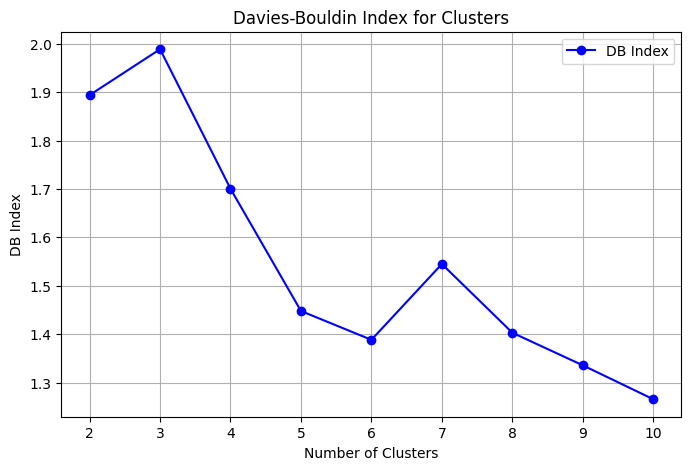

Optimal Number of Clusters: 10
Minimum DB Index: 1.2654


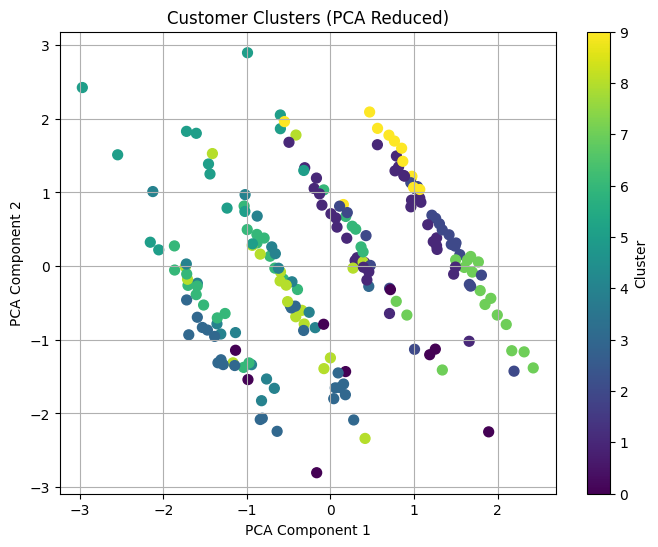

Clustering completed with 10 clusters.
  CustomerID  Cluster
0      C0001        2
1      C0002        4
2      C0003        1
3      C0004        7
4      C0005        4


In [3]:
# Preprocessing: Convert date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets on CustomerID
data = pd.merge(customers, transactions, on='CustomerID', how='left')

# Feature Engineering
data['Recency'] = (datetime.now() - data['TransactionDate']).dt.days
data['Tenure'] = (datetime.now() - data['SignupDate']).dt.days
data['TotalSpend'] = data.groupby('CustomerID')['TotalValue'].transform('sum')
data['Frequency'] = data.groupby('CustomerID')['TransactionID'].transform('count')
data['Monetary'] = data['TotalSpend'] / data['Frequency']

# Keep one row per customer with aggregated features
final_data = data[['CustomerID', 'Region', 'Tenure', 'Recency', 'Frequency', 'Monetary']].drop_duplicates()

# Handle missing values
print(final_data.isnull().sum())
final_data.dropna(inplace=True)

# Handle missing values without inplace
final_data['Recency'] = final_data['Recency'].fillna(final_data['Recency'].mean())
final_data['Monetary'] = final_data['Monetary'].fillna(final_data['Monetary'].mean())


# Aggregate features by CustomerID to ensure uniqueness
final_data = final_data.groupby('CustomerID', as_index=False).agg({
    'Region': 'first',
    'Tenure': 'mean',
    'Recency': 'mean',
    'Frequency': 'sum',
    'Monetary': 'mean',
})

# Encode categorical features (Region)
le = LabelEncoder()
final_data['Region'] = le.fit_transform(final_data['Region'])

# Normalize numerical features
scaler = StandardScaler()
features = ['Tenure', 'Recency', 'Frequency', 'Monetary']
final_data[features] = scaler.fit_transform(final_data[features])

# Clustering
X = final_data[features + ['Region']]
db_scores = []

# Determine optimal clusters using DB Index
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)
    db_scores.append(davies_bouldin_score(X, clusters))

# Plot DB Index for different cluster counts
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), db_scores, marker='o', color='b', label='DB Index')
plt.title('Davies-Bouldin Index for Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.legend()
plt.grid()
plt.show()

# Select optimal number of clusters (minimum DB Index)
optimal_k = np.argmin(db_scores) + 2
print(f'Optimal Number of Clusters: {optimal_k}')
print(f'Minimum DB Index: {min(db_scores):.4f}')

# Apply K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_data['Cluster'] = kmeans.fit_predict(X)

# Visualize clusters using PCA (2D scatterplot)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=final_data['Cluster'], cmap='viridis', s=50)
plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

# Save clustering results
final_data.to_csv("Sumant_Lokhande_Clustering.csv", index=False)

# Print clustering summary
print(f"Clustering completed with {optimal_k} clusters.")
print(final_data[['CustomerID', 'Cluster']].head())
